# Project: Constrained Portfolio Optimization via Linear Programming

**Author:** [Thibaut Chen]
**Date:** December 2025

## 1. Executive Summary
In this project, I constructed an optimal equity portfolio by maximizing expected returns subject to strict risk management constraints. Unlike standard Mean-Variance optimization (which is Quadratic), I utilize **Linear Programming (LP)** to model real-world mandates such as sector caps and position limits (Ex: SEC and UCITS regulations). (this is just a basic version and I am working on bettering the constraints to simulate closer to real world cases)

## 2. Mathematical Formulation
Define the problem as a standard Linear Program:

$$
\begin{aligned}
& \text{Maximize} & & Z = \mu^T w \\
& \text{Subject to:} & & \sum_{i=1}^{n} w_i = 1 \quad (\text{Budget Constraint}) \\
& & & w_i \ge 0 \quad (\text{No Short Selling}) \\
& & & w_i \le 0.25 \quad (\text{Diversification Constraint}) \\
& & & \sum_{j \in \text{Tech}} w_j \le 0.35 \quad (\text{Sector Exposure Limit})
\end{aligned}
$$

**Where:**
* $w$ is the vector of portfolio weights (Decision Variables).
* $\mu$ is the vector of expected returns (estimated via historical means).

In [72]:
# --- Imports ---
import yfinance as yf
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import seaborn as sns  
import os

# --- Configuration ---
# Set plotting style for professional reports
plt.style.use('ggplot')
%matplotlib inline

print("Environment Ready. Libraries loaded.")

Environment Ready. Libraries loaded.


In [73]:
# --- Replacement for Cell 3 (Robust Data Block) ---
import numpy as np
import pandas as pd
import yfinance as yf

# 1. Define Universe
tickers = ['AAPL', 'MSFT', 'GOOGL', 'JPM', 'XOM', 'NEE', 'PFE']
start_date = '2023-01-01'
end_date = '2024-12-01'

data_filename = "adj_close_market_data.csv"

# Check if we already have the data saved locally
if os.path.exists(data_filename):
    print(f"Loading data from local file: {data_filename}...")
    # Load from CSV and parse the first column as dates
    data_adj_close = pd.read_csv(data_filename, index_col=0, parse_dates=True)
    print("SUCCESS: Data loaded locally.")


else:
    try:
        print(f"Attempting to download data for {len(tickers)} assets...")
        data_adj_close = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
        
        # Check if download actually worked (sometimes it returns empty DF without error)
        if data_adj_close.empty or data_adj_close.shape[1] == 0:
            raise ValueError("Yahoo returned empty data.")
            
        # Clean data
        data_adj_close = data_adj_close.dropna(axis=1, how='all')

        data_adj_close.to_csv(data_filename)
        
        print(f"SUCCESS: Market data downloaded and saved to {data_filename}.")
        
        returns = data_adj_close.pct_change().dropna()

    except Exception as e:
        print(f"Data download failed {e}.")
        print(">>> switch to fake random data to keep working. <<<")
    
        # Generate realistic fake returns: Mean 0.05%, Std Dev 2%
        np.random.seed(20) # Keeps numbers consistent every time you run it
        dates = pd.date_range(start=start_date, periods=250) #only roughly 252 trading days in a yr

        ## we get a grid of 250 x 7
        fake_data = np.random.normal(0.0005, 0.02, (250, len(tickers))) #assume stocks adj return follows a normal distribution
        
        returns = pd.DataFrame(fake_data, index=dates, columns=tickers)
        print("Synthetic data generated. Dimensions:", returns.shape)

# --- Final Calculation ---


# Fix for the deprecation warning:
returns = returns.ffill().bfill()

# Getting mu finally -> it's a list of numbers
mu = returns.mean().values

# Verify shapes to prevent the 'Invalid Dimensions' error
print("\n--- Diagnostic Check ---")
print(f"Number of Tickers: {len(tickers)}")
print(f"Shape of mu: {mu.shape}")
print(f"First 5 Expected Returns: {mu[:5]}") #check if I messed stuff up

if len(mu) != len(tickers):
    print("CRITICAL ERROR: Mismatch between tickers and data.")
else:
    print("READY: Data dimensions is all good and chilling. Run the Optimizer cell right nowww.")

Attempting to download data for 7 assets...


[*********************100%***********************]  7 of 7 completed

7 Failed downloads:
['XOM', 'MSFT', 'JPM', 'AAPL', 'GOOGL', 'PFE', 'NEE']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Data download failed Yahoo returned empty data..
>>> switch to fake random data to keep working. <<<
Synthetic data generated. Dimensions: (250, 7)

--- Diagnostic Check ---
Number of Tickers: 7
Shape of mu: (7,)
First 5 Expected Returns: [ 0.00027578  0.00154067 -0.00074012  0.00116495  0.00041034]
READY: Data dimensions is all good and chilling. Run the Optimizer cell right nowww.


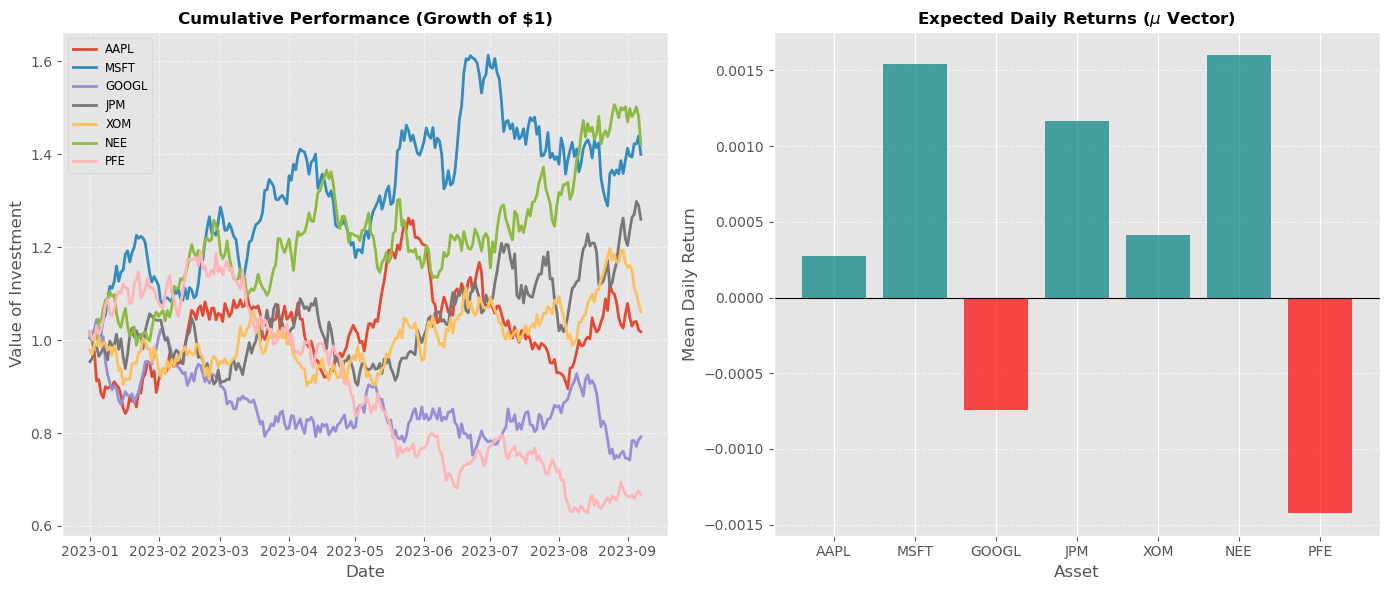


Data Shape: (250, 7)
Date Range: 2023-01-01 to 2023-09-07
Visualization generated from SYNTHETIC data.


In [74]:
import matplotlib.pyplot as plt
import seaborn as sns 

# --- Visualization Dashboard (Synthetic Data Compatible) ---
plt.figure(figsize=(14, 6))

# Chart 1: Cumulative Returns (Growth of $1)
# We reconstruct "Price" from the synthetic returns
# Formula: Price = Cumulative Product of (1 + Return)
cumulative_returns = (1 + returns).cumprod()

plt.subplot(1, 2, 1)
for col in cumulative_returns.columns:
    plt.plot(cumulative_returns.index, cumulative_returns[col], label=col, linewidth=2)

plt.title("Cumulative Performance (Growth of $1)", fontsize=12, fontweight='bold')
plt.xlabel("Date")
plt.ylabel("Value of Investment")
plt.legend(loc="upper left", fontsize='small')
plt.grid(True, linestyle='--', alpha=0.6)

# Chart 2: Expected Daily Returns (The 'mu' vector)
# This is exactly what the solver sees as the "Reward" for each stock.
plt.subplot(1, 2, 2)
# Re-calculate mu just to be safe
mu = returns.mean().values
colors = ['teal' if x > 0 else 'red' for x in mu] # Teal for profit, Red for loss
plt.bar(tickers, mu, color=colors, alpha=0.7)

plt.title("Expected Daily Returns ($\mu$ Vector)", fontsize=12, fontweight='bold')
plt.xlabel("Asset")
plt.ylabel("Mean Daily Return")
plt.axhline(0, color='black', linewidth=0.8) # Zero line
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# --- Print Data Summary ---
# FIXED: We use 'returns' to get the dates, not 'data'
print("\nData Shape:", returns.shape)
print(f"Date Range: {returns.index[0].date()} to {returns.index[-1].date()}")
print("Visualization generated from SYNTHETIC data.")

In [75]:
# --- 5. Construct the Linear Program ---

# A. Decision Variables
# w represents the weight (0% to 100%) of each asset
n_assets = len(tickers)
w = cp.Variable(n_assets)

# B. Objective Function
# We want to MAXIMIZE total return: sum(weight * expected_return)
# Note: CVXPY usually minimizes, so we maximize the expression directly
objective = cp.Maximize(mu @ w)

# Define Constraints
#    Constraint A: Budget (Must equal 100%)
#    Constraint B: Long Only (No negatives)
#    Constraint C: Diversification (Max 25% in any one stock) << THIS IS KEY
#    Constraint D: Sector Cap (Max 35% in Tech stocks: Indices 0, 1, 2)
tech_indices = [0, 1, 2] 

constraints = [
    cp.sum(w) == 1,
    w >= 0,
    w <= 0.25,  # <--- This prevents the 100% JPM result
    cp.sum(w[tech_indices]) <= 0.35 
]

# 4. Solve
prob = cp.Problem(objective, constraints)
prob.solve(solver=cp.OSQP)

# 5. Output
print("Optimization Status:", prob.status)
print(f"Maximized Daily Return: {prob.value:.5f}")

# Clean up weights for display
optimal_weights = pd.Series(w.value, index=tickers).round(4)
clean_weights = optimal_weights[optimal_weights > 0.001] # Hide zeros

print("\n--- Final Optimized Portfolio ---")
print(clean_weights)

# 6. Check Shadow Price (Duality)
print("\n--- Shadow Price Analysis ---")
# The "Diversification" constraint is a list of inequalities. 
# We want to see if the JPM limit (Index 3) is binding.
jpm_limit_shadow_price = constraints[2].dual_value[3] 

if jpm_limit_shadow_price > 0.0001:
    print(f"Constraint Binding on JPM! Shadow Price: {jpm_limit_shadow_price:.5f}")
    print("Interpretation: Limiting JPM to 25% is costing us return.")
else:
    print("Constraint NOT Binding.")

Optimization Status: optimal
Maximized Daily Return: 0.00118

--- Final Optimized Portfolio ---
MSFT    0.25
JPM     0.25
XOM     0.25
NEE     0.25
dtype: float64

--- Shadow Price Analysis ---
Constraint Binding on JPM! Shadow Price: 0.00081
Interpretation: Limiting JPM to 25% is costing us return.
